# Introduction 
This notebook gives a complete synthetic exemple of elastic modulus identification from images. 

We consider a tensile test of a rectangular specimen. The constitutive material is caracterised by a Youg's modulus distribution $E(x,y)$ to be identified and a Poisson's coefficient which is supposed to be known ($\nu=0.3$). The length of the specimen is $L = 20~\mathrm{mm}$, its heigth is $H=50~\mathrm{mm}$. The resultant force of the tensile test is $F=1000~\mathrm{N}$. 
This example is synthetic: the data are drawned from a finite element simulation (FEniCS).

Importe packages

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from mpl_toolkits.axes_grid1 import make_axes_locatable

from package import Class_DIC as dic
from package.Class_Inputs import Inputs
from package.Mechanics_model import create_mesh_E, E_function
from package.Class_Observations import Observations
from package.Class_Metamodel_E2 import MetaModel
from package import display

Set parameters of the simulation

In [14]:
device = torch.device('cpu')

# Physical parameters of the specimen 
length = 20 # in mm
heigth = 50 # in mm

# Image parameters
nb_px_row = 2048 # number of pixel along the rows
nb_px_col = 589 # number of pixel along the columns

# ratio to go from pixel to real world coordinate system
ratio_x = length / nb_px_col
ratio_y = heigth / nb_px_row

# Inputs of the simulation
coloc_inputs  = Inputs(device, N_coloc = [40,100], N_coloc_bc=[100, 100, 500, 500], nbr_hlines=500,
                  variable_boundaries=[[0., length], [0., heigth]])
obs_dci = Observations('solution_reference_lineaire_2GPa_1000N.txt', -1, stdu=0.0)

n_E    = [20,40] # number of element, along x-axis and y-axis resp., of the mesh defining E_h

def Efunc(x): # ground-truth solution for the Young modulus E
    return 2000 - 1000 * x[:,1] / heigth

# Initialisation of the metamodel
metamodel = MetaModel(device, coloc_inputs, layers = [2, 50, 50, 50],
                       E_0 = 2000.*torch.ones(((n_E[0]+1)*(n_E[1]+1))), E_ref = 2000, E_interpolation='P1', n_E = n_E,
                      Fourier_features=False, sigma_FF_u=0, sigma_FF_sigma=0,
                      verbose=1,
                      Efunc = Efunc,
                      seed = 3112001)

# Retrain mdoels
retrain_DIC   = False
retrain_sigma = False

In [15]:
"""
fig, ax = plt.subplots(figsize=(10,10))

fine_mesh = create_mesh_E(coloc_inputs, n_E = [100, 100]) # fine mesh to evaluate E(x,y)
E_solution  = E_function(torch.from_numpy(fine_mesh.nodes), metamodel.E_solution, metamodel, coloc_inputs) # Interpolation of E(x,y) on the fine mesh
h = ax.imshow(E_solution.reshape(101,101).T/1000, 
              cmap='jet',extent = [0,20,0,50], origin = 'lower')
clb = plt.colorbar(h)
clb.set_label(r'$E(x,y)$ \ [GPa]', labelpad=-40, y=1.05, rotation=0)

ax = metamodel.mesh_E.plot(ax) # scatter plot of the mesh 
ax.annotate("", xytext=(10., 51.), xy=(10., 55.),
            arrowprops=dict(arrowstyle="->", color='r', linewidth=5),zorder=4)
ax.annotate("", xytext=(10., -1.), xy=(10., -5.),
            arrowprops=dict(arrowstyle="->", color='r', linewidth=5),zorder=4)
ax.annotate("F", xytext = (8., 53.), xy = (8., 53.), fontsize = 16., fontweight = 'bold', color = 'r')
ax.annotate("F", xytext = (8., -3.), xy = (8., -3.), fontsize = 16., fontweight = 'bold', color = 'r')

ax.set_aspect('equal', adjustable='box')
ax.set_ylim([-6,56])
ax.set_xlabel(r'$x$ \ [mm]')
ax.set_ylabel(r'$y$ \ [mm]')

plt.suptitle("Colormap of the ground-truth Young's modulus distribution\n" + r"and scatter plot of the mesh defining $E_h$")
plt.show()
"""

<>:9: SyntaxWarning: invalid escape sequence '\ '
<>:9: SyntaxWarning: invalid escape sequence '\ '
C:\Users\Elsa_Ehrhart\AppData\Local\Temp\ipykernel_11996\3671563588.py:9: SyntaxWarning: invalid escape sequence '\ '
  clb.set_label(r'$E(x,y)$ \ [GPa]', labelpad=-40, y=1.05, rotation=0)


'\nfig, ax = plt.subplots(figsize=(10,10))\n\nfine_mesh = create_mesh_E(coloc_inputs, n_E = [100, 100]) # fine mesh to evaluate E(x,y)\nE_solution  = E_function(torch.from_numpy(fine_mesh.nodes), metamodel.E_solution, metamodel, coloc_inputs) # Interpolation of E(x,y) on the fine mesh\nh = ax.imshow(E_solution.reshape(101,101).T/1000, \n              cmap=\'jet\',extent = [0,20,0,50], origin = \'lower\')\nclb = plt.colorbar(h)\nclb.set_label(r\'$E(x,y)$ \\ [GPa]\', labelpad=-40, y=1.05, rotation=0)\n\nax = metamodel.mesh_E.plot(ax) # scatter plot of the mesh \nax.annotate("", xytext=(10., 51.), xy=(10., 55.),\n            arrowprops=dict(arrowstyle="->", color=\'r\', linewidth=5),zorder=4)\nax.annotate("", xytext=(10., -1.), xy=(10., -5.),\n            arrowprops=dict(arrowstyle="->", color=\'r\', linewidth=5),zorder=4)\nax.annotate("F", xytext = (8., 53.), xy = (8., 53.), fontsize = 16., fontweight = \'bold\', color = \'r\')\nax.annotate("F", xytext = (8., -3.), xy = (8., -3.), fontsi

# Image Correlation

## Generation of data
We import the reference and deformed image. The reference image, $I_0$ is a real speckle which was deformed with the ground-truth displacement field to obtain the deformed image $I_t$. 

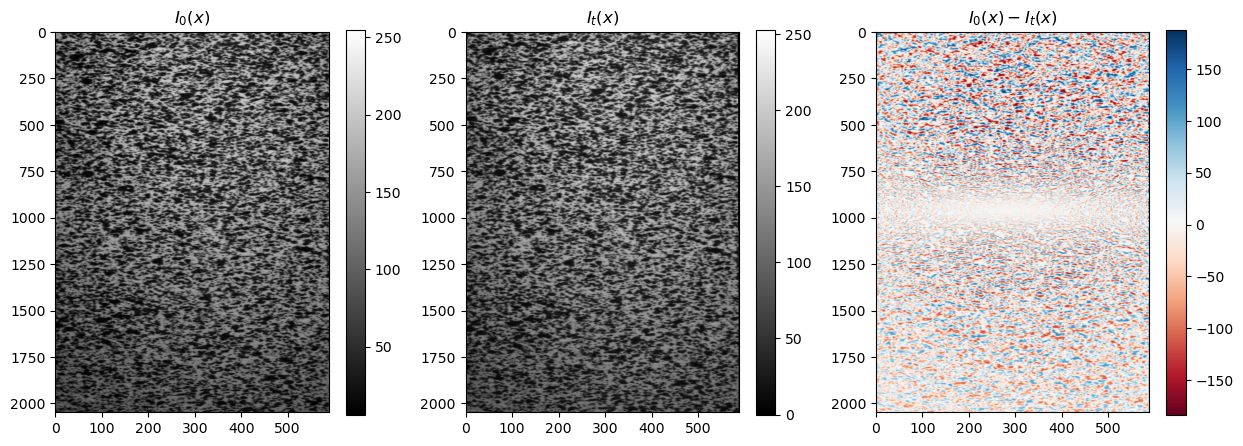

In [16]:
''' Generation of the image of reference '''
I_0 = np.loadtxt('I_0.txt')

''' Computation of the deformed image '''
I_t = np.loadtxt('I_t.txt')

''' Display the two images and the grey-level residual '''
fig, axs = plt.subplots(1,3,figsize = (15,5))

h = axs[0].imshow(I_0, cmap='gray')
plt.colorbar(h, ax=axs[0])
axs[0].set_title(r'$I_0(x)$')
axs[0].set_aspect(length/heigth)

h = axs[1].imshow(I_t, cmap='gray')
plt.colorbar(h, ax=axs[1])
axs[1].set_title(r'$I_t(x)$')
axs[1].set_aspect(length/heigth)

h = axs[2].imshow(I_0 - I_t, cmap='RdBu')
plt.colorbar(h, ax=axs[2])
axs[2].set_title(r'$I_0(x)-I_t(x)$')
axs[2].set_aspect(length/heigth)

## Minimisation of the grey-level residual
Then, we initialise a PINN-displacement model $\hat{v}_{\theta_v}$, which is trained by minimising the DIC functional:
$$ 
\theta_v = \underset{\theta}{\mathrm{arg~min}}\sum_{x}\big(I_0(x)-I_t(x+\hat{v}(x;\theta))\big)^2
$$

In [17]:
# From now on, everything is dealed with in Pytorch
I_0_torch = torch.from_numpy(I_0)
I_t_torch = torch.from_numpy(I_t)

index_row = torch.arange(0, I_0_torch.shape[0])
index_col = torch.arange(0, I_t_torch.shape[1])

X, Y = torch.meshgrid(index_row, index_col)
train_set = torch.vstack((X.flatten(), Y.flatten())).T
dic_model = dic.DIC(I_0_torch, I_t_torch, train_set, [length, heigth])

if retrain_DIC:   
    metamodel.pretrain_u(coloc_inputs, dic_model, pre_train_iter = 1500)

    # Save results
    torch.save(metamodel.model_u, 'model_u_after_DIC.pth')
    loss_monitoring = np.asarray(np.asarray(metamodel.list_J_train)[:,2])
    np.savetxt('loss_DIC.txt', loss_monitoring)

    
else:
    metamodel.model_u = torch.load('model_u_after_DIC.pth',weights_only=False)

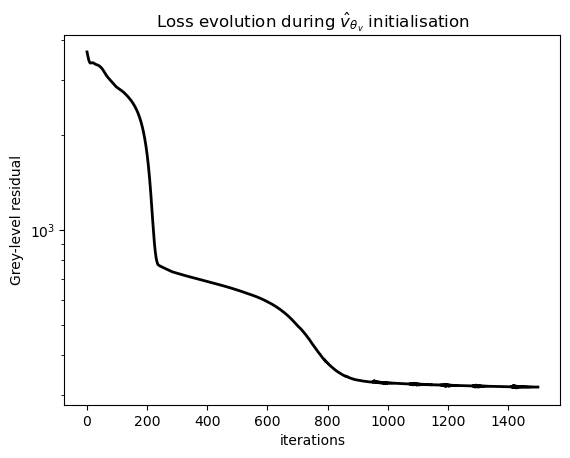

In [18]:
if retrain_DIC:
    fig, ax = plt.subplots()
    ax.semilogy(loss_monitoring, c = 'k', linewidth = 2.)
    ax.set_xlabel(r'iterations')
    ax.set_ylabel(r'Grey-level residual')
    ax.set_title(r'Loss evolution during $\hat{v}_{\theta_v}$ initialisation')
    plt.show()
    
else:
    loss_monitoring = np.loadtxt('loss_DIC.txt')
    fig, ax = plt.subplots()
    ax.semilogy(loss_monitoring, c = 'k', linewidth = 2.)
    ax.set_xlabel(r'iterations')
    ax.set_ylabel(r'Grey-level residual')
    ax.set_title(r'Loss evolution during $\hat{v}_{\theta_v}$ initialisation')
    plt.show()

## Analysis of the results
It seems that the gradient descent converged. Let check that the resultant displacement field indeed allows $I_0$ and $I_t$ to match. To do so, we plot the grey-level residual map. 

In [19]:
I_0_predict = dic_model.reconstruction(train_set, I_0_torch, I_t_torch, metamodel.model_u)

residu = I_0.flatten() - I_0_predict
maxi = 3*np.std(np.abs(residu))

fig, axs = plt.subplots(1,2,figsize = (10,5))

ax = axs[0]
h = ax.imshow(residu.reshape(I_0.shape), vmin = - maxi, vmax = maxi, cmap = 'RdBu')
plt.colorbar(h, ax = ax)
ax.set_aspect(length/heigth)
ax.set_title(r'$I_0(x)-I_t(x+\hat{v}_{\theta_v}(x))$')

ax = axs[1]
h = ax.imshow(I_0 - I_t, vmin = - maxi, vmax = maxi, cmap = 'RdBu')
plt.colorbar(h, ax=ax)
ax.set_title(r'$I_0(x)-I_t(x)$')
ax.set_aspect(length/heigth)
plt.show()

KeyboardInterrupt: 

The residual is well minimised within the domain. One can see that they are some problems at the top and bottom edges which is due to how we generate the deformed image. 

Let now compare the obtained displacement field with the ground-truth solution.

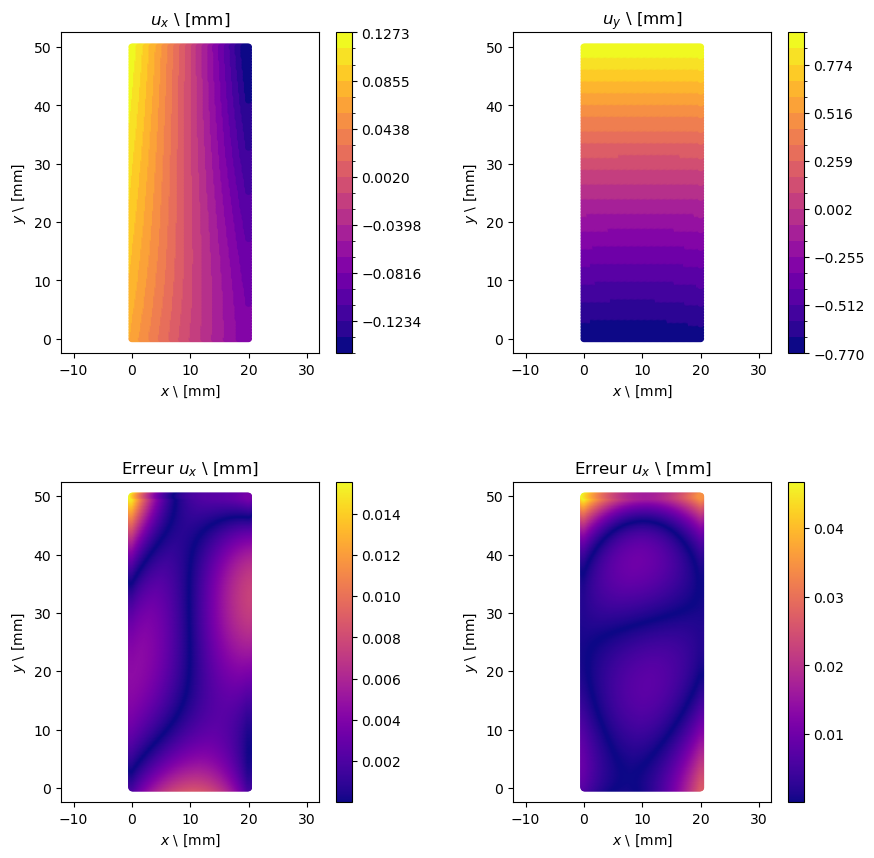

In [ ]:
display.display_u(metamodel, coloc_inputs, obs_dci, display_error = True)

# Initialisation of the stress field
We previously properly initialised the displacement field thanks to the image data we had experimentally. Now, we must do a similar step for the stress field. This is done by minimising:
$$
J_{\sigma}^{\mathrm{init}} = \lambda_{\mathrm{res}}J_{\mathrm{res}}+\lambda_{\mathrm{obs}}^{F^\sigma}J_{\mathrm{obs}}^{F^\sigma}+\lambda_{BC}J_{BC}+\lambda_{\mathrm{const}}J_{\mathrm{const}}
$$
with:
- $ J_{\mathrm{res}} = \frac{1}{n_{\mathrm{col}}}\sum_{j=1}^{n_{\mathrm{col}}}\|\mathrm{div}\big(C(\mathbf{p})\nabla_s\hat{\sigma}_{\theta_\sigma}(x^j_{\mathrm{xcol}},~y^j_{\mathrm{ycol}}\big)\|_2^2$ corresponds to the local equilibrium equation;
- $ J_{\mathrm{obs}}^{F^\sigma} = \frac{1}{n_{\mathrm{col}_\mathrm{line}}} \sum_{l=1}^{n_{\mathrm{col}_\mathrm{line}}} \Big(F_{\mathrm{obs}} - \int_{\Gamma_l} \left[ \hat{\sigma}_{\theta_\sigma} \,  \mathbf{e}_y \right] \cdot \mathbf{e}_y \, \mathrm{d}\Gamma \Big)^2_2$ corresponds to the global equilibrium of each horizontal line of the specimen;
- $ J_{BC} = \frac{1}{n_{\mathrm{col}_\mathrm{BC}}} \sum_{j=1}^{n_{\mathrm{col}_\mathrm{BC}}} \left\|  \hat{\sigma}_{\theta_\sigma} \big(x^j_{\mathrm{xcol}_\mathrm{BC}},\ x^j_{\mathrm{ycol}_\mathrm{BC}} \big) \, n\big(x^j_{\mathrm{xcol}_\mathrm{BC}},\ x^j_{\mathrm{ycol}_\mathrm{BC}} \big) \right\|_2^2 $ corresponds to the statical boundary conditions;
- $ J_{\mathrm{const}} = \frac{1}{n_\mathrm{col}} \sum_{j=1}^{n_\mathrm{col}} \left\| \hat{\sigma}_{\theta_\sigma} \big(x^j_{\mathrm{xcol}},\ x^j_{\mathrm{ycol}}\big) -   C\big(E_h,\nu \big) \, \nabla_s \hat{v}_{\theta_v} \big(x^j_{\mathrm{xcol}},\ x^j_{\mathrm{ycol}}\big) \right\|_2^2 $ corresponds to the constitutive equation.

Several key points must be noticed:
- The statical equations (local equilibrium, boundary conditions) are not sufficient, in general, to uniquely define the stress field state. The latter depends of the kinematic part of the problem, to which it is linked through the constitutive equation. However, as we do not know the constitutive parameters for the moment, the link between the kinematic and statical part of the problems is wrong. Consequently, the learned stress field $\hat{\sigma}_{\theta_\sigma}$ from the minimisation of $J_{\sigma}^{\mathrm{init}}$ is likely to be wrong from a mechanical point of view. 
- In the same vein, in this initialisation part, $J_{\mathrm{const}}$ plays the role of a "data" term, as the displacement was previously learned. But this data term is misguiding as the constitutive parameters are not known/
- Thus, the mechanical terms $ J_{\mathrm{res}},~J_{\mathrm{obs}}^{F^\sigma},~J_{BC}$ aims to lead $\hat{\sigma}_{\theta_\sigma}$ towards a mechanically consistent solution.

In [ ]:
if retrain_sigma:
    metamodel.is_sigma_trained = True
    metamodel.pretrain_sigma(coloc_inputs, pre_train_iter = 500, lambdas={'res' : 0.01, 'obs' : 0, 'obs_F':0, 'BC':1., 'lines':1., 'constitutive':1})
    
    #Save results
    torch.save(metamodel.model_sigma, 'model_sigma_pretrained.pth')
    np.savetxt('loss_sigma.txt', np.asarray(metamodel.list_J_train))

else:
    metamodel.model_sigma = torch.load('model_sigma_pretrained.pth',weights_only=False)

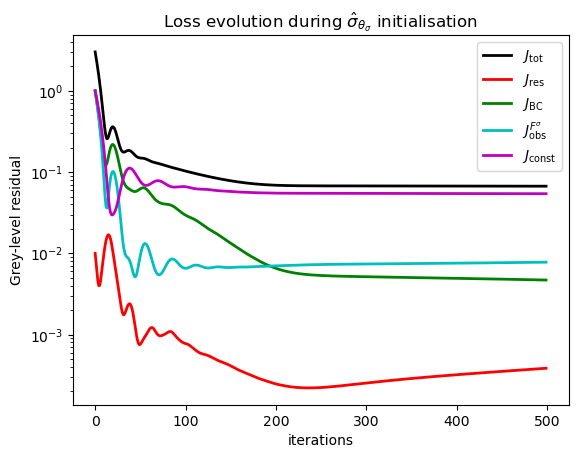

In [ ]:
if retrain_sigma:
    loss_monitoring = np.asarray(metamodel.list_J_train)
    
else:
    loss_monitoring = np.loadtxt('loss_sigma.txt')

fig, ax = plt.subplots()
ax.semilogy(loss_monitoring[:,0], c = 'k', linewidth = 2., label = r'$J_{\mathrm{tot}}$')
ax.semilogy(loss_monitoring[:,1], c = 'r', linewidth = 2., label = r'$J_{\mathrm{res}}$')
ax.semilogy(loss_monitoring[:,4], c = 'g', linewidth = 2., label = r'$J_{\mathrm{BC}}$')
ax.semilogy(loss_monitoring[:,5], c = 'c', linewidth = 2., label = r'$J_{\mathrm{obs}}^{F^\sigma}$')
ax.semilogy(loss_monitoring[:,6], c = 'm', linewidth = 2., label = r'$J_{\mathrm{const}}$')
ax.set_xlabel(r'iterations')
ax.set_ylabel(r'Grey-level residual')
ax.set_title(r'Loss evolution during $\hat{\sigma}_{\theta_\sigma}$ initialisation')
plt.legend()
plt.show()

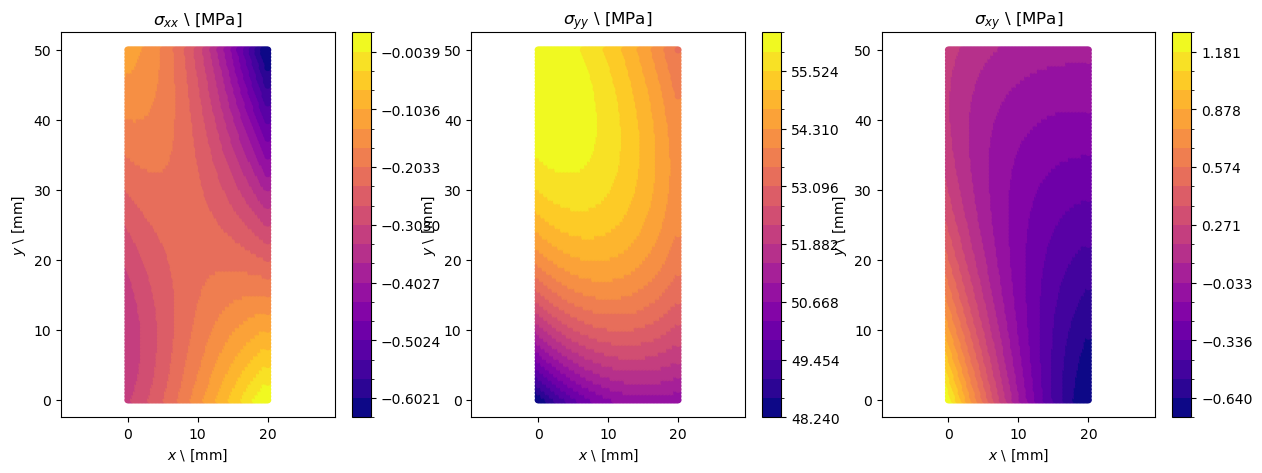

In [ ]:
display.display_sigma(metamodel, coloc_inputs, Fobs = 50)

## Fixed-point algorithm

The final step is to carry-out the minimisation of $J_{\mathrm{PINN}}$ with respect to the different set of parameters $E_h,~\theta_{v},~\theta_{\sigma}$. This is done through a fixed-point to mitigate the different sensitivites of $J_{\mathrm{PINN}}$ to the different parameters. 

In [ ]:
metamodel.train_model(coloc_inputs, dic_model, alter_steps=10 , 
                    alter_freq=(10, 10, 10),
                    lambdas_identif_E = {'res' : 0, 'obs' : 0, 'obs_F_u':10, 'BC':0, 'obs_F_sigma':0, 'constitutive':1},
                    lambdas_update_sigma = {'res' : 0.001, 'obs' : 0, 'obs_F_u':0, 'BC':0.001, 'obs_F_sigma':0.1, 'constitutive':1},
                    lambdas_update_u = {'res' : 0, 'obs' : 0.1, 'obs_F_u':10, 'BC':0, 'obs_F_sigma':0, 'constitutive':1})

ITERATION n°0
 Loss:  2511.0263671875
Saving E 


c:\Users\Elsa_Ehrhart\Desktop\5A\projet\projet_PINN\package\display.py:25: SyntaxWarning: invalid escape sequence '\ '
  ax.set_title('Reference solution and data, $E = {} \ Pa$'.format(list(np.around(ref_solution['parameter'].detach().clone().cpu().numpy(),2))))
c:\Users\Elsa_Ehrhart\Desktop\5A\projet\projet_PINN\package\display.py:27: SyntaxWarning: invalid escape sequence '\ '
  ax.set_title('Reference solution, $E = {} \ Pa$'.format(list(np.around(ref_solution['parameter'].detach().clone().cpu().numpy(),2))))


AttributeError: 'MetaModel' object has no attribute 'E_solution'

In [ ]:
display.display_sigma(metamodel, coloc_inputs, 50.)
display.display_epsilon(metamodel, coloc_inputs)
display.display_u(metamodel, coloc_inputs, obs_dci, display_error=True)

In [ ]:
loss_monitoring = np.asarray(metamodel.list_J_train)[metamodel.list_iter_flag[:]]

fig, ax = plt.subplots()
ax.semilogy(loss_monitoring[:,0], c = 'k', linewidth = 2., label = r'$J_{\mathrm{tot}}$')
ax.set_xlabel(r'iterations')
ax.set_ylabel(r'Grey-level residual')
ax.set_title('Total loss evolution during the fixed-point')
plt.legend()
plt.show()